In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250527.csv to Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250527 (1).csv


In [ ]:
import pandas as pd
df = pd.read_csv("Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250527.csv")
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1918 entries, 1013 to 160
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1918 non-null   datetime64[ns]
 1   Local Route   1918 non-null   int64         
 2   Light Rail    1918 non-null   int64         
 3   Peak Service  1918 non-null   int64         
 4   Rapid Route   1918 non-null   int64         
 5   School        1918 non-null   int64         
 6   Other         1898 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 119.9 KB


,Date,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
1013,2019-07-01,15987,9962,407,21223,3715,NaN
1120,2019-07-02,16895,10656,409,21715,3993,NaN
1451,2019-07-03,16613,10658,427,22025,3638,NaN
1171,2019-07-04,16604,10445,437,21868,3576,NaN
1523,2019-07-05,16040,10532,400,20697,2856,NaN


In [ ]:
print(df.isna().sum())
df['Other'] = df['Other'].fillna(0)

Date             0
Local Route      0
Light Rail       0
Peak Service     0
Rapid Route      0
School           0
Other           20
dtype: int64


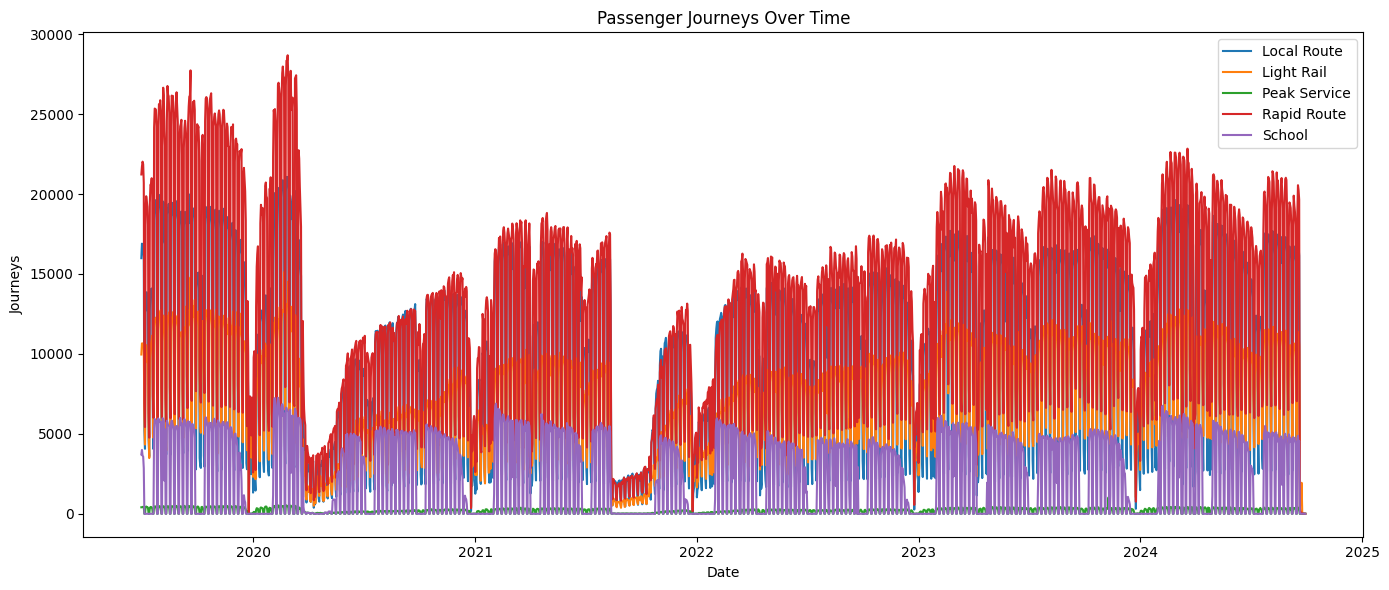

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(14, 6))
for col in ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']:
    plt.plot(df['Date'], df[col], label=col)
plt.title("Passenger Journeys Over Time")
plt.xlabel("Date")
plt.ylabel("Journeys")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
print(df[['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']].mean())

Local Route      9891.395203
Light Rail       7195.446298
Peak Service      179.581335
Rapid Route     12597.213243
School           2352.694995
dtype: float64


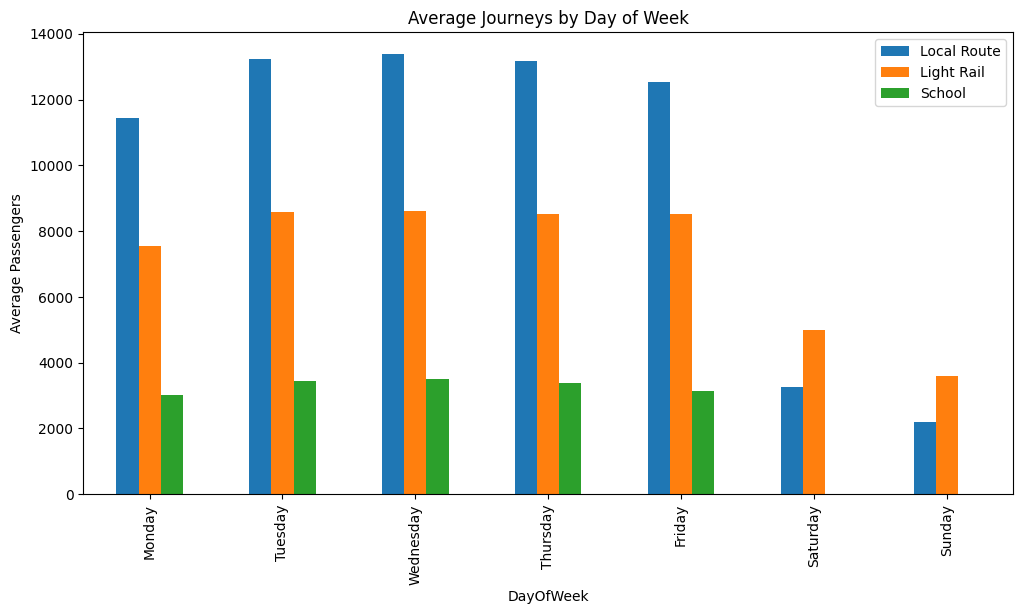

In [ ]:
df['DayOfWeek'] = df['Date'].dt.day_name()
avg_by_day = df.groupby('DayOfWeek')[['Local Route', 'Light Rail', 'School']].mean()

avg_by_day = avg_by_day.loc[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]  # ordered

avg_by_day.plot(kind='bar', figsize=(12, 6))
plt.title("Average Journeys by Day of Week")
plt.ylabel("Average Passengers")
plt.show()

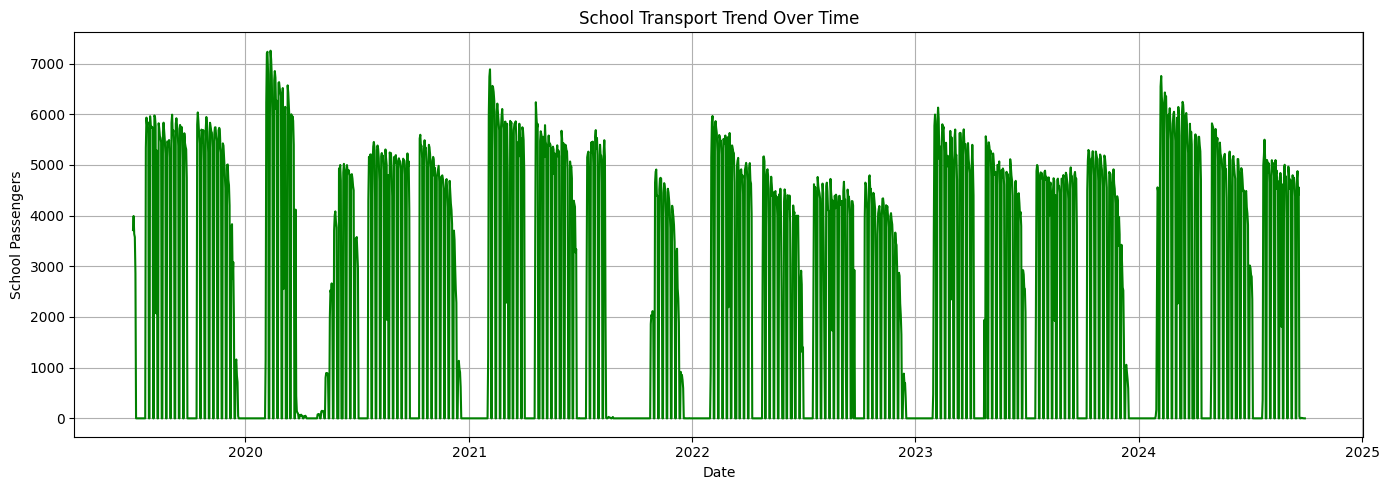

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(df['Date'], df['School'], color='green')
plt.title('School Transport Trend Over Time')
plt.xlabel('Date')
plt.ylabel('School Passengers')
plt.tight_layout()
plt.grid(True)
plt.show()


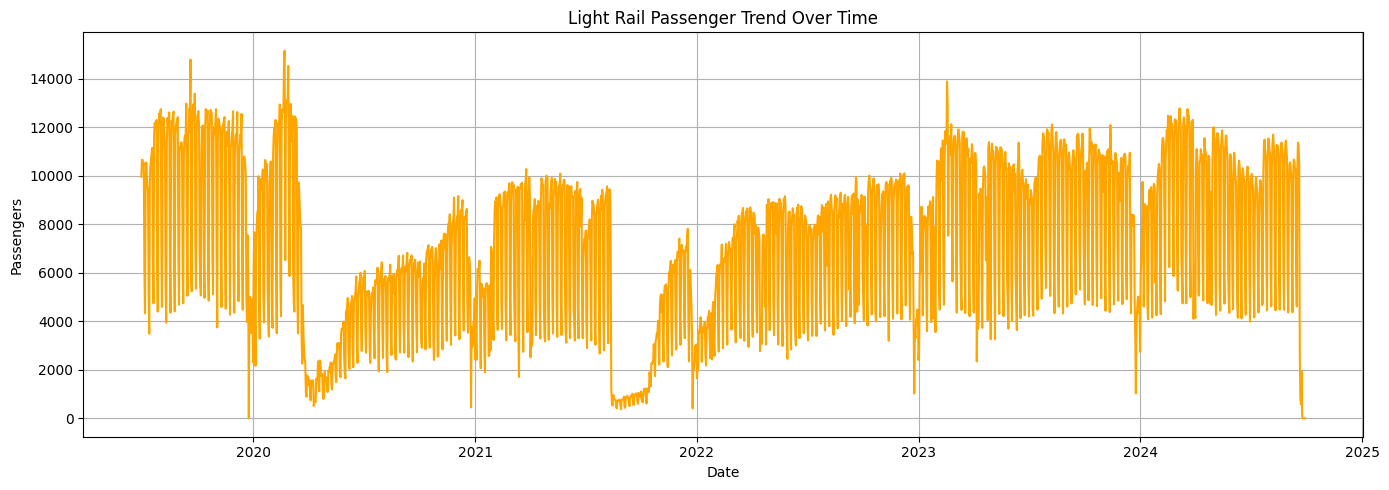

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(df['Date'], df['Light Rail'], color='orange')
plt.title('Light Rail Passenger Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers[['Date', column]]

# Find outliers for each column
outlier_local = detect_outliers_iqr(df, 'Local Route')
outlier_rail = detect_outliers_iqr(df, 'Light Rail')
outlier_peak = detect_outliers_iqr(df, 'Peak Service')
outlier_rapid = detect_outliers_iqr(df, 'Rapid Route')
outlier_school = detect_outliers_iqr(df, 'School')
print("Local Route Outliers:", len(outlier_local))
print("Light Rail Outliers:", len(outlier_rail))
print("Peak Service Outliers:", len(outlier_peak))
print("Rapid Route Outliers:", len(outlier_rapid))
print("School Outliers:", len(outlier_school))
# Display full row for the Peak Service outlier
outlier_peak_full = df[df['Date'].isin(outlier_peak['Date'])]
outlier_peak_full

Local Route Outliers: 0
Light Rail Outliers: 0
Peak Service Outliers: 1
Rapid Route Outliers: 0
School Outliers: 0


,Date,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
798,2023-11-10,16397,11100,1029,19102,4550,81.0


In [ ]:
!pip install prophet


In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd

def forecast_service(df, column_name, periods=7):
    data = df[['Date', column_name]].rename(columns={'Date': 'ds', column_name: 'y'})
    model = Prophet(daily_seasonality=True)
    model.fit(data)

    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)

    # Plot forecast
    model.plot(forecast)
    plt.title(f"{column_name} Forecast for Next {periods} Days")
    plt.xlabel("Date")
    plt.ylabel("Passengers")
    plt.grid(True)
    plt.show()

    # Return only the forecasted period values as a table
    forecast_result = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(periods)
    forecast_result = forecast_result.rename(columns={
        'ds': 'Date',
        'yhat': 'Predicted',
        'yhat_lower': 'Lower Bound',
        'yhat_upper': 'Upper Bound'
    })
    return forecast_result


DEBUG:cmdstanpy:input tempfile: /tmp/tmp2yh4a20u/tj19gt5f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2yh4a20u/w4qacu29.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88976', 'data', 'file=/tmp/tmp2yh4a20u/tj19gt5f.json', 'init=/tmp/tmp2yh4a20u/w4qacu29.json', 'output', 'file=/tmp/tmp2yh4a20u/prophet_model65fndmtu/prophet_model-20250527061650.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:16:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:16:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


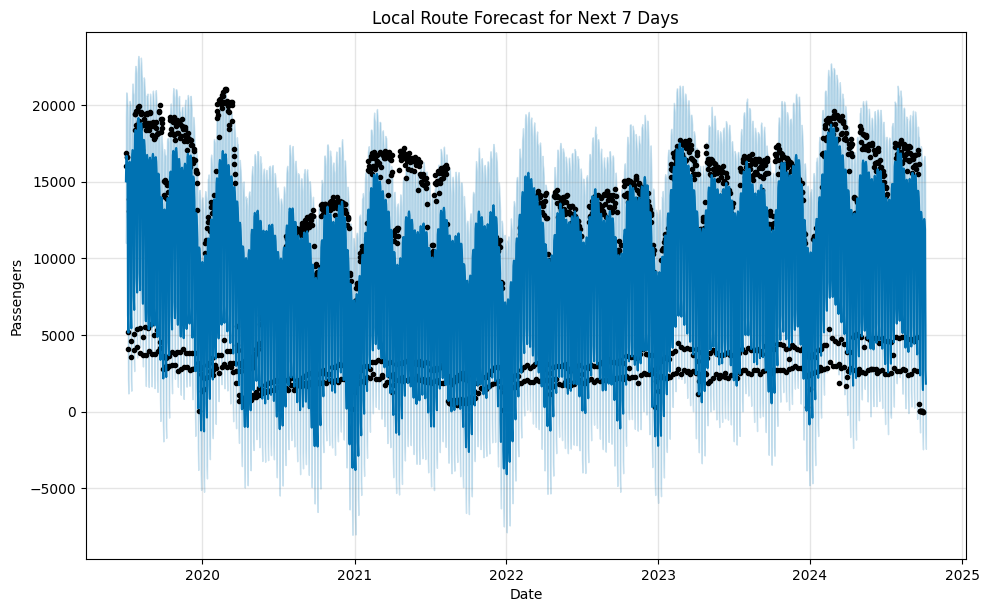

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2yh4a20u/yidaowb8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2yh4a20u/fr3bqevl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5376', 'data', 'file=/tmp/tmp2yh4a20u/yidaowb8.json', 'init=/tmp/tmp2yh4a20u/fr3bqevl.json', 'output', 'file=/tmp/tmp2yh4a20u/prophet_model76gt4kq2/prophet_model-20250527061651.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:16:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:16:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


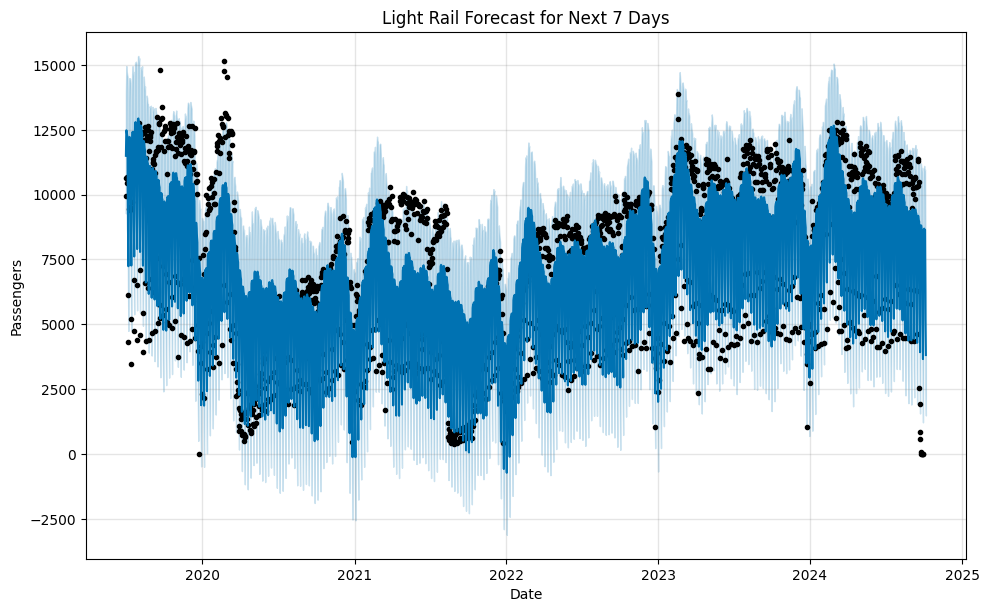

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2yh4a20u/jlv_vhc_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2yh4a20u/m21sm0nd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34011', 'data', 'file=/tmp/tmp2yh4a20u/jlv_vhc_.json', 'init=/tmp/tmp2yh4a20u/m21sm0nd.json', 'output', 'file=/tmp/tmp2yh4a20u/prophet_modelpkyuuyrd/prophet_model-20250527061653.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:16:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:16:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


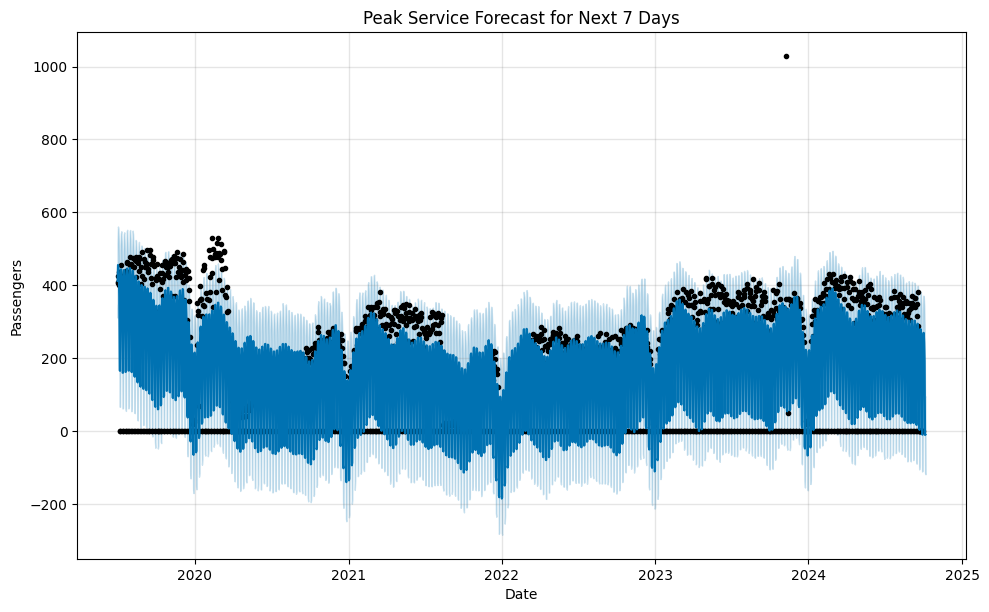

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2yh4a20u/h833q3mi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2yh4a20u/8w80t3sk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97381', 'data', 'file=/tmp/tmp2yh4a20u/h833q3mi.json', 'init=/tmp/tmp2yh4a20u/8w80t3sk.json', 'output', 'file=/tmp/tmp2yh4a20u/prophet_modeluy2j70vd/prophet_model-20250527061656.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:16:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:16:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


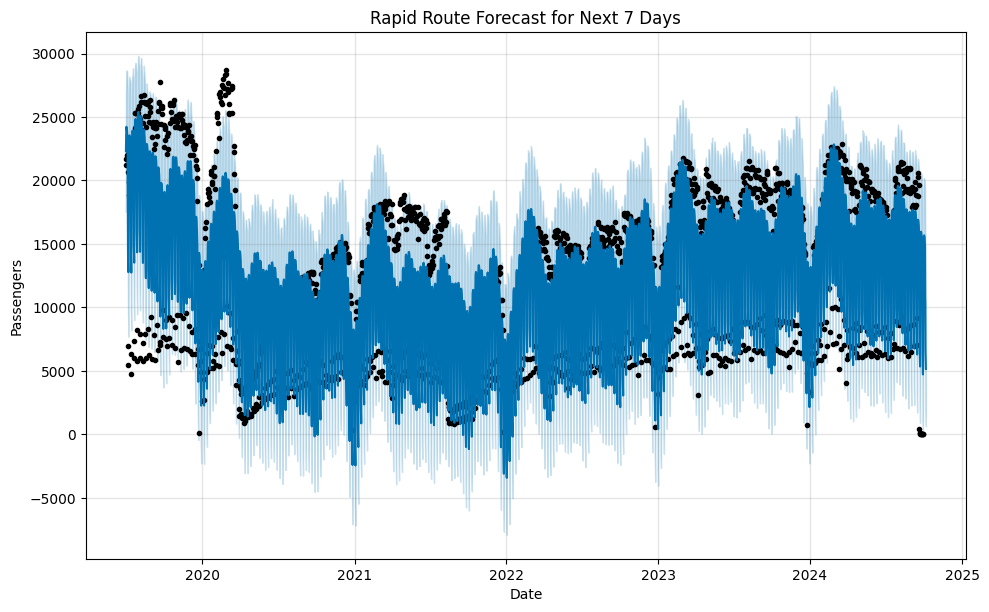

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2yh4a20u/yr1s_1dl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2yh4a20u/0o_q5_el.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44206', 'data', 'file=/tmp/tmp2yh4a20u/yr1s_1dl.json', 'init=/tmp/tmp2yh4a20u/0o_q5_el.json', 'output', 'file=/tmp/tmp2yh4a20u/prophet_modelos1037ff/prophet_model-20250527061657.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:16:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:16:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


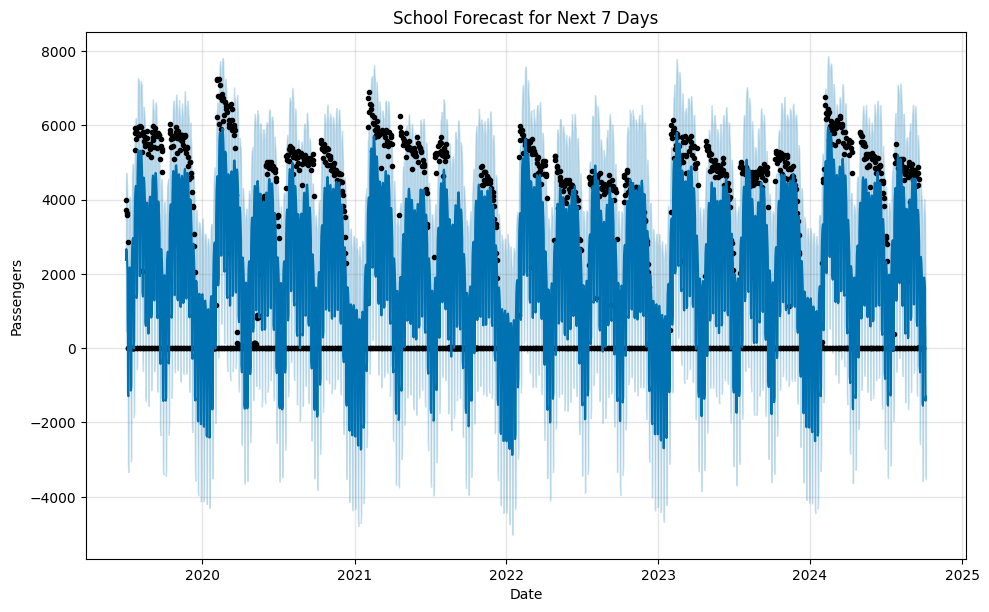

In [ ]:
local_forecast = forecast_service(df, 'Local Route')
light_rail_forecast = forecast_service(df, 'Light Rail')
peak_forecast = forecast_service(df, 'Peak Service')
rapid_forecast = forecast_service(df, 'Rapid Route')
school_forecast = forecast_service(df, 'School')


In [ ]:
print("Local Route Forecast:\n", local_forecast)
print("\nLight Rail Forecast:\n", light_rail_forecast)

Local Route Forecast:
            Date     Predicted  Lower Bound   Upper Bound
1918 2024-09-30  10604.954137  6570.888924  14738.609723
1919 2024-10-01  12400.855765  8047.623755  16211.441761
1920 2024-10-02  12566.008440  8660.097965  16921.202177
1921 2024-10-03  12416.321971  8474.764931  16551.781056
1922 2024-10-04  11887.572365  7957.665621  15957.500622
1923 2024-10-05   2740.268529 -1207.975973   6704.975088
1924 2024-10-06   1815.879469 -2065.225928   6248.127120

Light Rail Forecast:
            Date    Predicted  Lower Bound   Upper Bound
1918 2024-09-30  7590.700042  5308.907985   9936.445399
1919 2024-10-01  8644.581147  6247.085298  11014.729069
1920 2024-10-02  8687.169451  6243.644401  10901.652283
1921 2024-10-03  8606.459058  6171.397858  11048.001213
1922 2024-10-04  8636.435429  6410.407071  11036.154210
1923 2024-10-05  5172.417213  2784.127689   7611.083314
1924 2024-10-06  3814.737775  1402.089856   6152.266435


DEBUG:cmdstanpy:input tempfile: /tmp/tmp2yh4a20u/pqe78gd4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2yh4a20u/3g97s18n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59282', 'data', 'file=/tmp/tmp2yh4a20u/pqe78gd4.json', 'init=/tmp/tmp2yh4a20u/3g97s18n.json', 'output', 'file=/tmp/tmp2yh4a20u/prophet_model1l4i5irh/prophet_model-20250527060842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:08:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:08:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


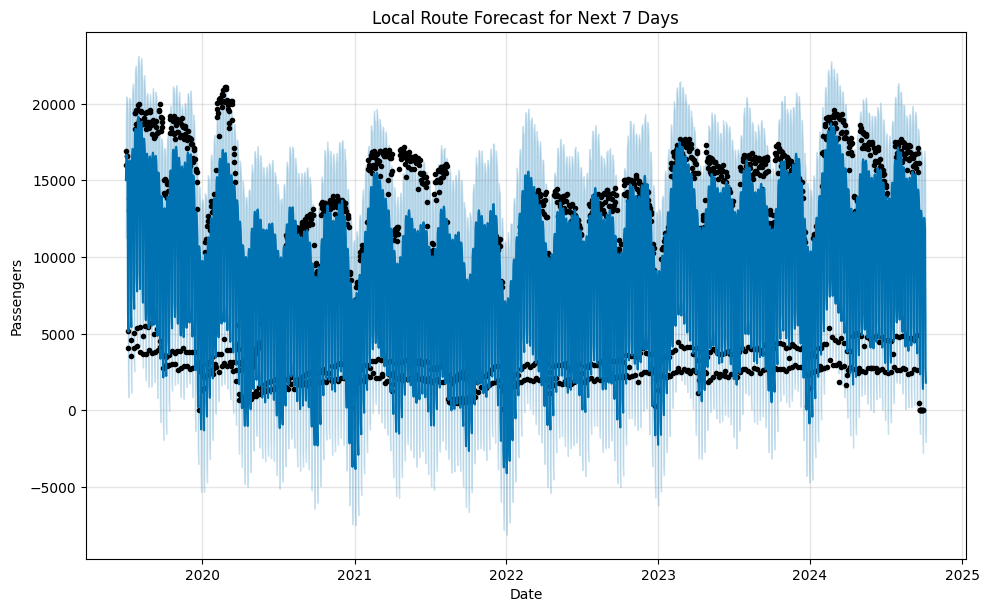

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2yh4a20u/4gddxsp8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2yh4a20u/6ch4wzfg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81328', 'data', 'file=/tmp/tmp2yh4a20u/4gddxsp8.json', 'init=/tmp/tmp2yh4a20u/6ch4wzfg.json', 'output', 'file=/tmp/tmp2yh4a20u/prophet_modell8qg6vw7/prophet_model-20250527060844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:08:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:08:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


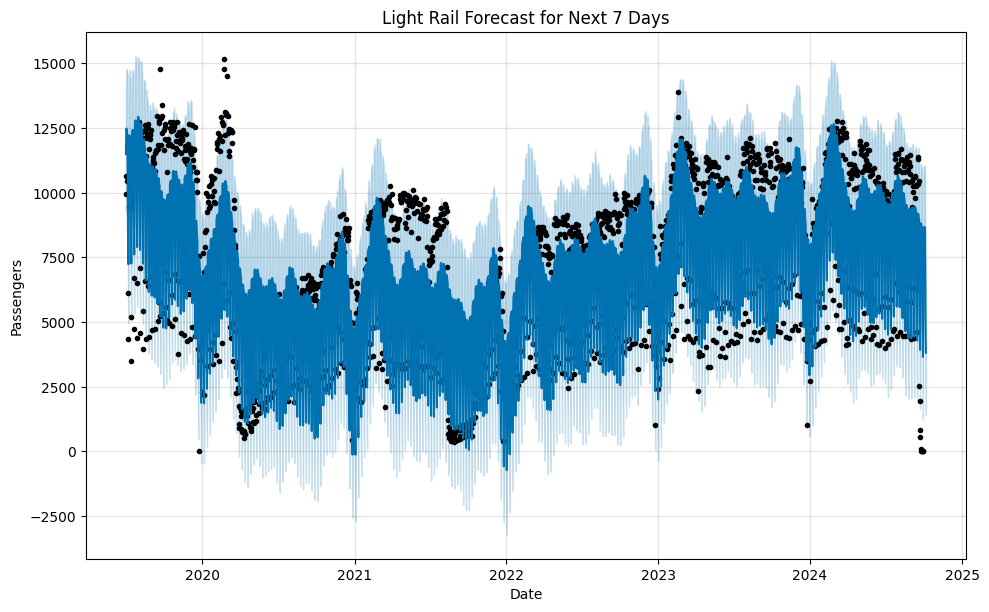

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2yh4a20u/8u_xysx_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2yh4a20u/vc7uw7yr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28241', 'data', 'file=/tmp/tmp2yh4a20u/8u_xysx_.json', 'init=/tmp/tmp2yh4a20u/vc7uw7yr.json', 'output', 'file=/tmp/tmp2yh4a20u/prophet_model1tnqk3bh/prophet_model-20250527060846.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:08:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:08:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


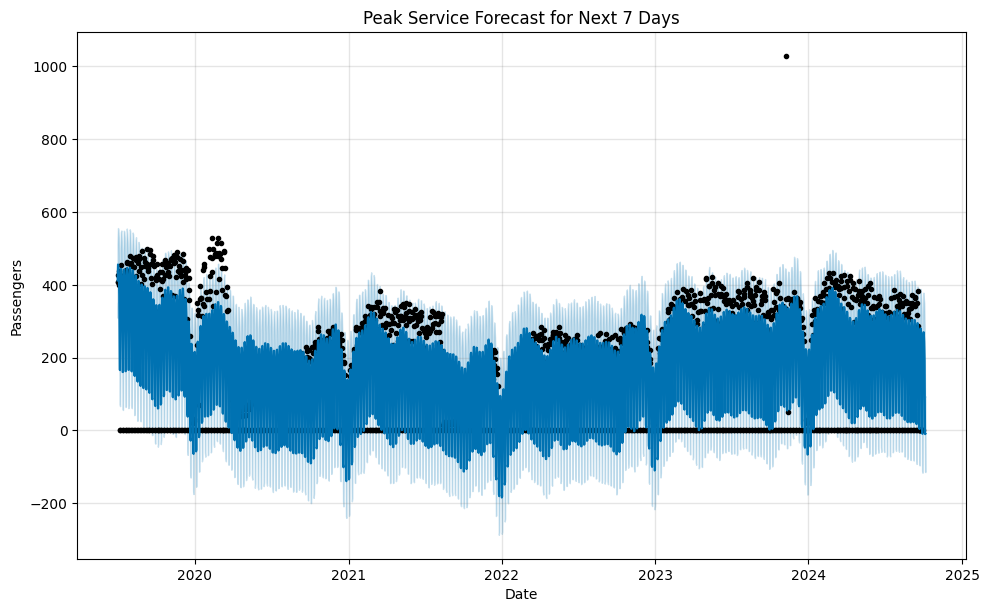

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2yh4a20u/25lmxzhu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2yh4a20u/xpb61tx1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84273', 'data', 'file=/tmp/tmp2yh4a20u/25lmxzhu.json', 'init=/tmp/tmp2yh4a20u/xpb61tx1.json', 'output', 'file=/tmp/tmp2yh4a20u/prophet_modelrxfdd55x/prophet_model-20250527060848.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:08:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:08:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


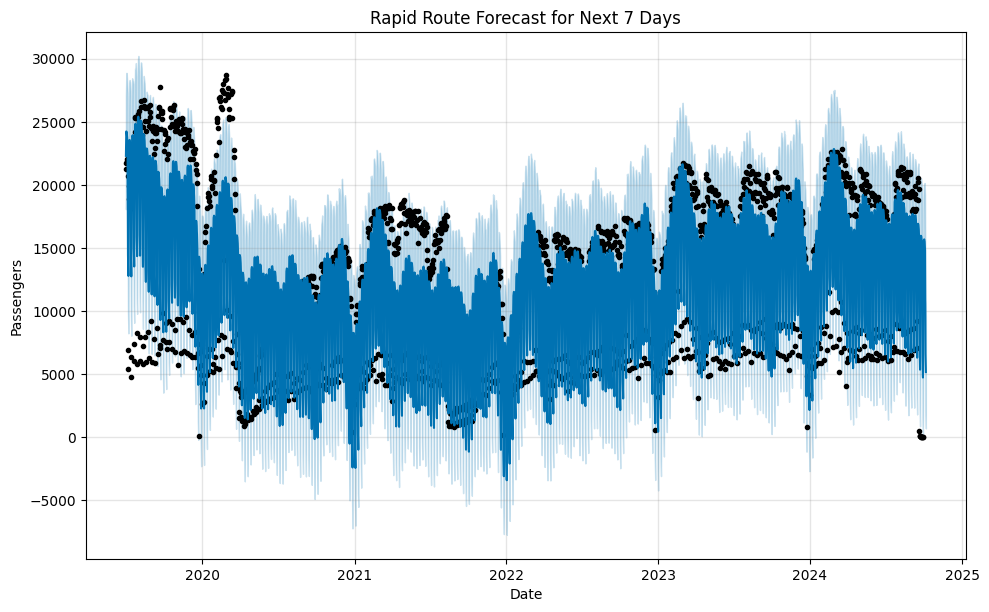

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2yh4a20u/8vou92vo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2yh4a20u/wqudro45.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79057', 'data', 'file=/tmp/tmp2yh4a20u/8vou92vo.json', 'init=/tmp/tmp2yh4a20u/wqudro45.json', 'output', 'file=/tmp/tmp2yh4a20u/prophet_model0sb2rwr8/prophet_model-20250527060849.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:08:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:08:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


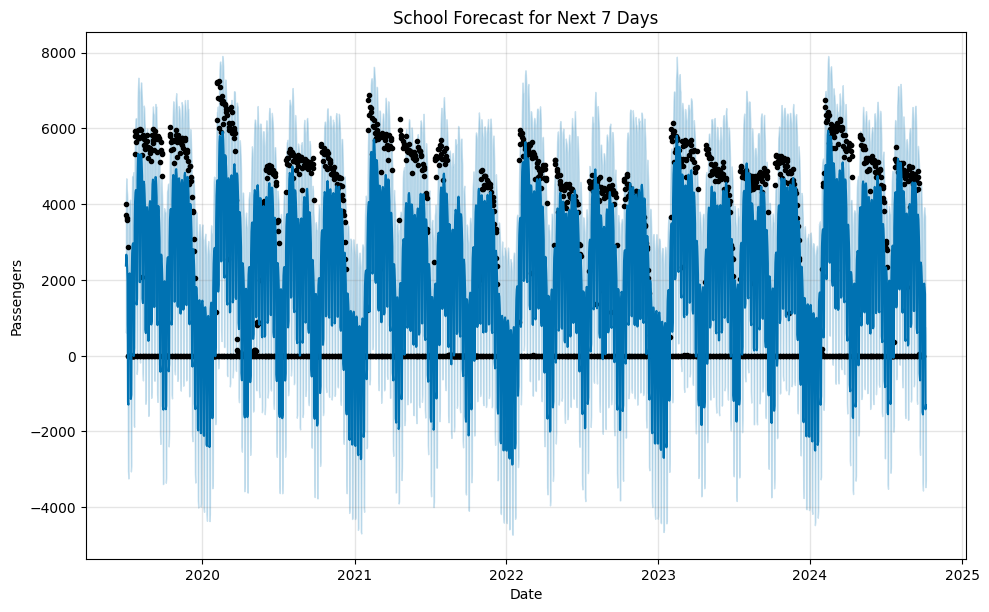

In [ ]:
local_forecast = forecast_service(df, 'Local Route')
light_rail_forecast = forecast_service(df, 'Light Rail')
peak_forecast = forecast_service(df, 'Peak Service')
rapid_forecast = forecast_service(df, 'Rapid Route')
school_forecast = forecast_service(df, 'School')
